迭代 0, 损失: 0.708064
迭代 100, 损失: 0.671182
迭代 200, 损失: 0.629126
迭代 300, 损失: 0.551816
迭代 400, 损失: 0.466575
迭代 500, 损失: 0.380730
迭代 600, 损失: 0.272105
迭代 700, 损失: 0.181098
迭代 800, 损失: 0.122372
迭代 900, 损失: 0.086452
迭代 1000, 损失: 0.064264
迭代 1100, 损失: 0.049986
迭代 1200, 损失: 0.040335
迭代 1300, 损失: 0.033508
迭代 1400, 损失: 0.028486
迭代 1500, 损失: 0.024668
迭代 1600, 损失: 0.021687
迭代 1700, 损失: 0.019304
迭代 1800, 损失: 0.017362
迭代 1900, 损失: 0.015754
迭代 1999, 损失: 0.014415
训练集准确率: 100.00%


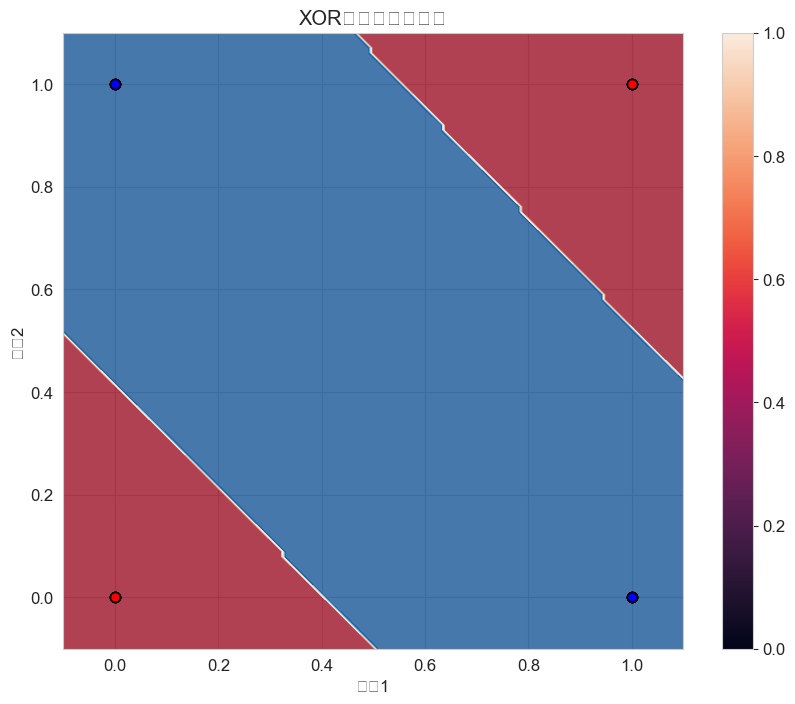

可视化迭代 0 的网络与传播过程


TypeError: subplot_spec must be type SubplotSpec, usually from GridSpec, or axes.get_subplotspec.

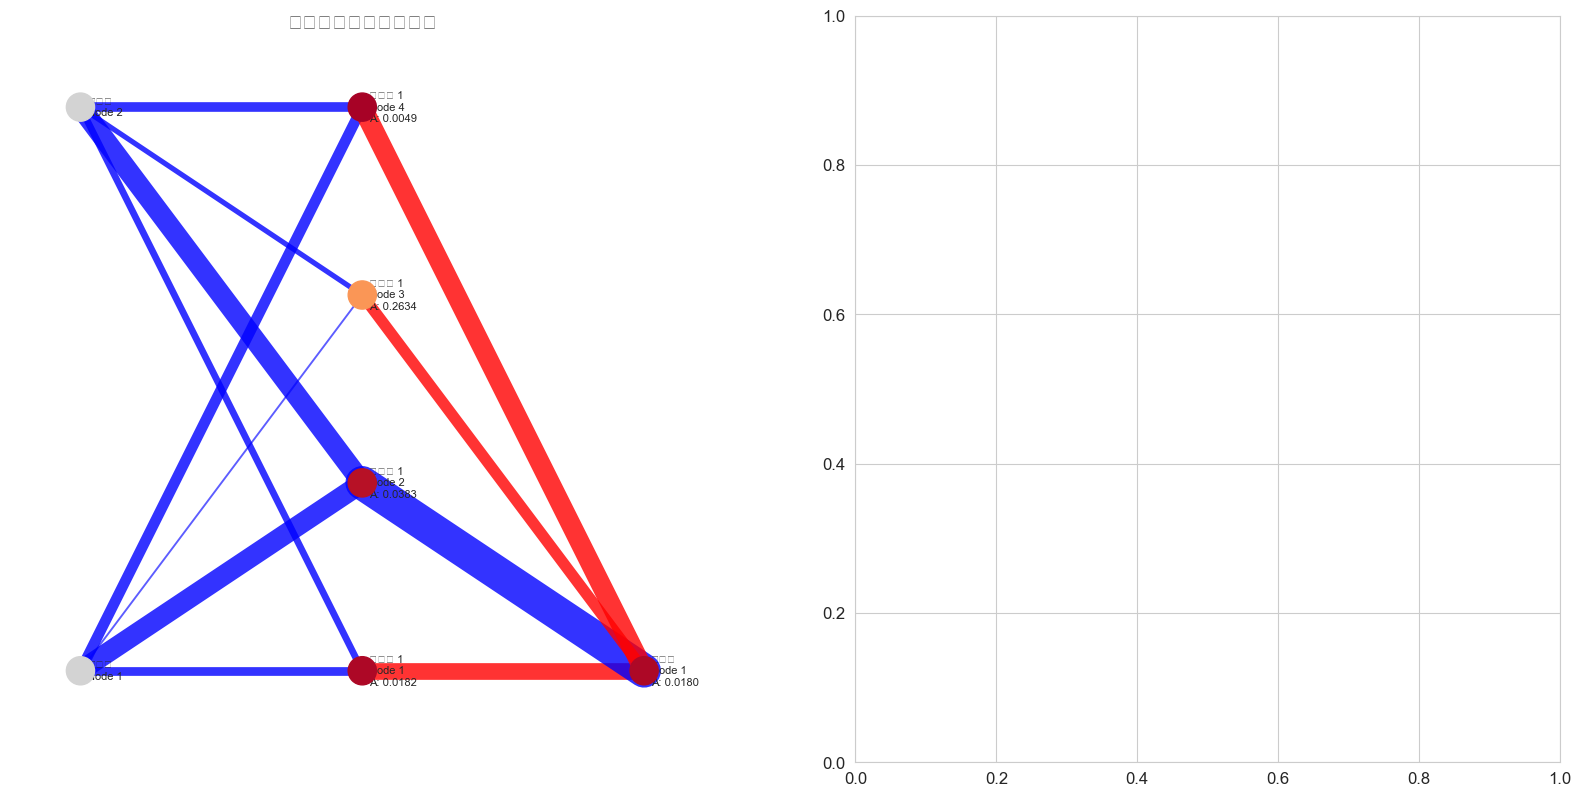

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
from IPython.display import display, Math, HTML, clear_output
import time
import matplotlib.gridspec as gridspec

# 设置更好看的图表风格
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

class NeuralNetwork:
    def __init__(self, layers_dims, learning_rate=0.1, seed=42):
        """
        初始化神经网络
        
        参数:
        - layers_dims: 各层维度列表，如[2,3,1]表示输入层2个神经元，隐藏层3个神经元，输出层1个神经元
        - learning_rate: 学习率
        - seed: 随机种子，确保结果可复现
        """
        np.random.seed(seed)
        self.parameters = {}  # 存储权重和偏置
        self.gradients = {}   # 存储梯度
        self.cache = {}       # 存储前向传播中间值
        self.learning_rate = learning_rate
        self.L = len(layers_dims) - 1  # 层数（不包括输入层）
        self.layers_dims = layers_dims
        self.debug_info = []  # 存储调试信息
        self.costs = []       # 存储训练过程的损失
        
        # He初始化
        for l in range(1, len(layers_dims)):
            self.parameters[f"W{l}"] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2 / layers_dims[l-1])
            self.parameters[f"b{l}"] = np.zeros((layers_dims[l], 1))
            
    def sigmoid(self, Z):
        """Sigmoid激活函数"""
        return 1 / (1 + np.exp(-Z))
    
    def sigmoid_derivative(self, Z):
        """Sigmoid函数的导数"""
        s = self.sigmoid(Z)
        return s * (1 - s)
    
    def forward_propagation(self, X, record_detail=False):
        """
        前向传播
        
        参数:
        - X: 输入数据，形状(输入特征数, 样本数)
        - record_detail: 是否记录中间过程详情（用于可视化）
        
        返回:
        - AL: 输出层激活值
        """
        A = X
        self.cache["A0"] = X  # 存储输入层的激活值
        
        # 存储更详细的信息用于可视化
        if record_detail:
            self.debug_info = []
            self.debug_info.append({"layer": 0, "A": A.copy(), "stage": "input"})
        
        # 正向传播到L-1层
        for l in range(1, self.L + 1):
            A_prev = A
            W = self.parameters[f"W{l}"]
            b = self.parameters[f"b{l}"]
            
            # 线性部分: Z = W·A + b
            Z = np.dot(W, A_prev) + b
            
            # 非线性激活: A = g(Z)
            A = self.sigmoid(Z)
            
            # 缓存中间值
            self.cache[f"Z{l}"] = Z
            self.cache[f"A{l}"] = A
            
            if record_detail:
                # 记录每一步的计算过程
                self.debug_info.append({
                    "layer": l,
                    "W": W.copy(),
                    "b": b.copy(),
                    "Z": Z.copy(),
                    "A": A.copy(),
                    "A_prev": A_prev.copy(),
                    "stage": "forward"
                })
        
        return A  # 返回输出层激活值
    
    def compute_cost(self, AL, Y):
        """
        计算成本函数: 二元交叉熵
        
        参数:
        - AL: 输出层激活值，形状(输出单元数, 样本数)
        - Y: 真实标签，形状(输出单元数, 样本数)
        
        返回:
        - cost: 损失值
        """
        m = Y.shape[1]  # 样本数
        
        # 计算二元交叉熵损失
        logprobs = np.multiply(np.log(AL), Y) + np.multiply(np.log(1 - AL), 1 - Y)
        cost = -np.sum(logprobs) / m
        
        return cost
    
    def backward_propagation(self, Y, record_detail=False):
        """
        反向传播计算梯度
        
        参数:
        - Y: 真实标签
        - record_detail: 是否记录中间过程详情（用于可视化）
        
        返回:
        - gradients: 包含所有参数梯度的字典
        """
        m = Y.shape[1]  # 样本数
        gradients = {}
        
        # 获取输出层激活值
        AL = self.cache[f"A{self.L}"]
        
        # 计算输出层误差 (步骤1)
        # δ^(L) = -(y - a^(L)) * g'(z^(L))
        dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        
        if record_detail:
            delta_info = []
        
        # 从输出层开始反向传播
        dA_prev = dAL
        for l in reversed(range(1, self.L + 1)):
            # 获取当前层的Z值和上一层的激活值
            Z = self.cache[f"Z{l}"]
            A_prev = self.cache[f"A{l-1}"]
            
            # 计算对Z的偏导数 (delta值)
            # δ^(l) = dA * g'(Z)
            dZ = dA_prev * self.sigmoid_derivative(Z)
            
            # 计算对权重的偏导数
            # dW^(l) = δ^(l) · (A^(l-1))^T / m
            dW = np.dot(dZ, A_prev.T) / m
            
            # 计算对偏置的偏导数
            # db^(l) = sum(δ^(l)) / m
            db = np.sum(dZ, axis=1, keepdims=True) / m
            
            # 如果不是第一层，计算上一层的dA (用于步骤2的传播)
            if l > 1:
                W = self.parameters[f"W{l}"]
                # dA^(l-1) = (W^(l))^T · δ^(l)
                dA_prev = np.dot(W.T, dZ)
            
            # 存储梯度
            gradients[f"dW{l}"] = dW
            gradients[f"db{l}"] = db
            
            if record_detail:
                # 记录反向传播的详细过程
                delta_info.append({
                    "layer": l,
                    "dZ": dZ.copy(),
                    "dW": dW.copy(),
                    "db": db.copy(),
                    "dA_prev": dA_prev.copy() if l > 1 else None,
                    "stage": "backward"
                })
        
        if record_detail:
            # 按层从输入到输出的顺序添加反向传播信息
            for delta in reversed(delta_info):
                self.debug_info.append(delta)
        
        self.gradients = gradients
        return gradients
    
    def update_parameters(self, record_detail=False):
        """
        使用梯度下降更新参数
        
        参数:
        - record_detail: 是否记录更新过程（用于可视化）
        """
        for l in range(1, self.L + 1):
            # 更新权重: W = W - α·dW
            self.parameters[f"W{l}"] -= self.learning_rate * self.gradients[f"dW{l}"]
            # 更新偏置: b = b - α·db
            self.parameters[f"b{l}"] -= self.learning_rate * self.gradients[f"db{l}"]
            
            if record_detail:
                # 记录参数更新过程
                self.debug_info.append({
                    "layer": l,
                    "W_updated": self.parameters[f"W{l}"].copy(),
                    "b_updated": self.parameters[f"b{l}"].copy(),
                    "dW": self.gradients[f"dW{l}"].copy(),
                    "db": self.gradients[f"db{l}"].copy(),
                    "stage": "update"
                })
    
    def train(self, X, Y, num_iterations=1000, print_cost=True, record_detail=False):
        """
        训练神经网络
        
        参数:
        - X: 输入数据
        - Y: 真实标签
        - num_iterations: 迭代次数
        - print_cost: 是否打印损失
        - record_detail: 是否记录详细过程
        
        返回:
        - parameters: 训练后的参数
        """
        self.costs = []
        recorded_iterations = []
        
        # 如果要记录详细过程，选择几个关键迭代点记录
        if record_detail:
            # 选择几个关键迭代点记录详细信息
            log_points = [0, 1, 2, 5, 10, 50, 100, 
                          int(num_iterations/4), int(num_iterations/2), 
                          num_iterations-1]
            log_points = sorted(list(set([i for i in log_points if i < num_iterations])))
        
        for i in range(num_iterations):
            # 前向传播
            AL = self.forward_propagation(X, record_detail=(record_detail and i in log_points))
            
            # 计算成本
            cost = self.compute_cost(AL, Y)
            self.costs.append(cost)
            
            # 反向传播计算梯度
            self.backward_propagation(Y, record_detail=(record_detail and i in log_points))
            
            # 更新参数
            self.update_parameters(record_detail=(record_detail and i in log_points))
            
            # 如果记录了详细信息，保存当前迭代编号
            if record_detail and i in log_points:
                recorded_iterations.append(i)
            
            # 打印损失
            if print_cost and (i % 100 == 0 or i == num_iterations - 1):
                print(f"迭代 {i}, 损失: {cost:.6f}")
        
        return self.parameters, self.costs, recorded_iterations
    
    def predict(self, X):
        """
        使用训练好的网络进行预测
        
        参数:
        - X: 输入数据
        
        返回:
        - predictions: 预测结果 (0或1)
        """
        AL = self.forward_propagation(X)
        predictions = (AL > 0.5).astype(int)
        return predictions


# 可视化函数：显示网络结构和信息流
def visualize_network_structure(nn, X, Y, iteration_details):
    """
    可视化神经网络结构和前向/反向传播过程
    
    参数:
    - nn: 神经网络实例
    - X: 输入数据
    - Y: 真实标签
    - iteration_details: 记录不同迭代的详细信息
    """
    for iter_idx, (iteration, details) in enumerate(iteration_details):
        print(f"可视化迭代 {iteration} 的网络与传播过程")
        
        # 1. 创建一个大的Figure来包含所有可视化内容
        plt.figure(figsize=(20, 16))
        gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])
        
        # 2. 绘制网络结构和数据流
        ax1 = plt.subplot(gs[0, 0])
        plot_network_architecture(nn, details, ax1)
        
        # 3. 绘制权重热图
        ax2 = plt.subplot(gs[0, 1])
        plot_weight_heatmaps(nn, details, ax2)
        
        # 4. 绘制损失曲线
        ax3 = plt.subplot(gs[1, :])
        if len(nn.costs) > 0:
            iterations = np.arange(len(nn.costs))
            ax3.plot(iterations, nn.costs, label='训练损失')
            ax3.set_xlabel('迭代次数')
            ax3.set_ylabel('损失')
            ax3.set_title('训练损失曲线')
            ax3.legend()
            ax3.grid(True)
            # 标记当前迭代
            if iteration < len(nn.costs):
                ax3.scatter([iteration], [nn.costs[iteration]], color='red', s=100, zorder=5)
                ax3.annotate(f'当前迭代: {iteration}', 
                             xy=(iteration, nn.costs[iteration]),
                             xytext=(iteration+5, nn.costs[iteration]),
                             arrowprops=dict(facecolor='black', shrink=0.05),
                             fontsize=12)
        
        plt.tight_layout()
        plt.show()
        
        # 5. 显示详细的计算过程
        display_computation_details(details)
        
        # 为了不让输出太拥挤，增加一个分隔
        if iter_idx < len(iteration_details) - 1:
            display(HTML("<hr style='height:2px;border:none;color:#333;background-color:#333;' />"))


def plot_network_architecture(nn, details, ax=None):
    """绘制网络架构和数据流"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    # 获取网络层数和每层的神经元数量
    layer_sizes = nn.layers_dims
    n_layers = len(layer_sizes)
    
    # 设置节点位置
    layer_positions = np.linspace(0.1, 0.9, n_layers)
    node_positions = {}
    max_nodes = max(layer_sizes)
    
    # 为每个节点计算位置
    for l in range(n_layers):
        n_nodes = layer_sizes[l]
        positions = np.linspace(0.1, 0.9, n_nodes)
        for i in range(n_nodes):
            node_positions[(l, i)] = (layer_positions[l], positions[i])
    
    # 绘制连接
    forward_details = [d for d in details if d["stage"] == "forward"]
    backward_details = [d for d in details if d["stage"] == "backward"]
    
    # 绘制边
    for l in range(1, n_layers):
        W = nn.parameters[f"W{l}"]
        prev_layer_size = layer_sizes[l-1]
        curr_layer_size = layer_sizes[l]
        
        # 决定边的颜色和宽度
        for i in range(curr_layer_size):
            for j in range(prev_layer_size):
                weight = W[i, j]
                # 确定颜色：红色表示负权重，蓝色表示正权重
                color = 'red' if weight < 0 else 'blue'
                # 权重的绝对值决定线的宽度
                width = 0.5 + 2 * np.abs(weight)
                alpha = min(0.8, 0.2 + np.abs(weight))
                
                # 绘制边
                ax.plot([node_positions[(l-1, j)][0], node_positions[(l, i)][0]],
                        [node_positions[(l-1, j)][1], node_positions[(l, i)][1]],
                        color=color, linewidth=width, alpha=alpha)
    
    # 绘制节点
    for l in range(n_layers):
        layer_name = "输入层" if l == 0 else ("输出层" if l == n_layers-1 else f"隐藏层 {l}")
        for i in range(layer_sizes[l]):
            x, y = node_positions[(l, i)]
            # 判断当前节点是否有激活值
            has_activation = False
            activation_value = 0
            for d in forward_details:
                if d["layer"] == l and "A" in d:
                    has_activation = True
                    if i < d["A"].shape[0]:
                        activation_value = d["A"][i, 0]
                    break
            
            # 根据激活值设置节点颜色
            if has_activation:
                # 使用colormap来表示激活强度
                color = plt.cm.RdYlBu(activation_value)
            else:
                color = 'lightgray'
            
            # 绘制节点
            circle = plt.Circle((x, y), 0.02, color=color, zorder=10)
            ax.add_artist(circle)
            
            # 添加节点标签
            label = f"{layer_name}\nNode {i+1}"
            if has_activation:
                label += f"\nA: {activation_value:.4f}"
            ax.annotate(label, (x, y), xytext=(5, 0), textcoords="offset points", 
                        fontsize=8, ha='left', va='center')
    
    # 设置图表属性
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title("神经网络结构与数据流")
    
    return ax


def plot_weight_heatmaps(nn, details, ax=None):
    """绘制权重和梯度的热图"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    n_layers = len(nn.layers_dims)
    
    # 创建子图网格
    n_rows = n_layers - 1
    gs = gridspec.GridSpecFromSubplotSpec(n_rows, 2, subplot_spec=ax, wspace=0.3, hspace=0.4)
    
    # 为每层的权重和梯度创建热图
    for l in range(1, n_layers):
        # 获取当前层的权重
        W = nn.parameters[f"W{l}"]
        
        # 找到对应层的梯度信息
        dW = None
        for d in details:
            if d["stage"] == "backward" and d["layer"] == l and "dW" in d:
                dW = d["dW"]
                break
        
        # 绘制权重热图
        ax_w = plt.subplot(gs[l-1, 0])
        im_w = ax_w.imshow(W, cmap='RdBu_r', vmin=-np.abs(W).max(), vmax=np.abs(W).max())
        ax_w.set_title(f"第{l}层权重")
        plt.colorbar(im_w, ax=ax_w, fraction=0.046, pad=0.04)
        
        # 如果有梯度信息，绘制梯度热图
        if dW is not None:
            ax_dw = plt.subplot(gs[l-1, 1])
            im_dw = ax_dw.imshow(dW, cmap='RdBu_r', vmin=-np.abs(dW).max(), vmax=np.abs(dW).max())
            ax_dw.set_title(f"第{l}层权重梯度")
            plt.colorbar(im_dw, ax=ax_dw, fraction=0.046, pad=0.04)
    
    # 确保坐标轴标签清晰
    for ax in plt.gcf().get_axes():
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(8)
    
    return ax


def display_computation_details(details):
    """以可读格式显示计算过程的细节"""
    # 按阶段组织详细信息
    forward_details = [d for d in details if d["stage"] == "forward"]
    backward_details = [d for d in details if d["stage"] == "backward"]
    update_details = [d for d in details if d["stage"] == "update"]
    
    display(HTML("<h3>前向传播详细计算</h3>"))
    for d in forward_details:
        layer = d["layer"]
        if layer == 0:  # 输入层
            display(HTML(f"<b>输入层 (Layer 0)</b>"))
            if "A" in d:
                display(Math(r"A^{[0]} = " + np.array2string(d["A"], precision=4)))
        else:  # 隐藏层和输出层
            layer_name = "隐藏层" if layer < len(forward_details) else "输出层"
            display(HTML(f"<b>{layer_name} (Layer {layer})</b>"))
            if all(k in d for k in ["W", "b", "A_prev", "Z", "A"]):
                display(Math(r"Z^{[" + str(layer) + r"]} = W^{[" + str(layer) + r"]} \cdot A^{[" + str(layer-1) + r"]} + b^{[" + str(layer) + r"]}"))
                display(Math(r"A^{[" + str(layer) + r"]} = \sigma(Z^{[" + str(layer) + r"]})"))
    
    display(HTML("<h3>反向传播详细计算</h3>"))
    for d in reversed(backward_details):  # 反向顺序显示
        layer = d["layer"]
        layer_name = "输出层" if layer == len(backward_details) else f"隐藏层 {layer}"
        display(HTML(f"<b>{layer_name} (Layer {layer})</b>"))
        if all(k in d for k in ["dZ", "dW", "db"]):
            if layer == len(backward_details):  # 输出层
                display(Math(r"\delta^{[" + str(layer) + r"]} = \frac{\partial J}{\partial Z^{[" + str(layer) + r"]}} = \frac{\partial J}{\partial A^{[" + str(layer) + r"]}} \cdot \sigma'(Z^{[" + str(layer) + r"]})"))
            else:  # 隐藏层
                display(Math(r"\delta^{[" + str(layer) + r"]} = (W^{[" + str(layer+1) + r"]})^T \cdot \delta^{[" + str(layer+1) + r"]} \cdot \sigma'(Z^{[" + str(layer) + r"]})"))
            
            display(Math(r"\frac{\partial J}{\partial W^{[" + str(layer) + r"]}} = \frac{1}{m} \cdot \delta^{[" + str(layer) + r"]} \cdot (A^{[" + str(layer-1) + r"]})^T"))
            display(Math(r"\frac{\partial J}{\partial b^{[" + str(layer) + r"]}} = \frac{1}{m} \cdot \sum \delta^{[" + str(layer) + r"]}"))
    
    display(HTML("<h3>参数更新</h3>"))
    for d in update_details:
        layer = d["layer"]
        display(HTML(f"<b>Layer {layer}</b>"))
        if all(k in d for k in ["W_updated", "b_updated", "dW", "db"]):
            display(Math(r"W^{[" + str(layer) + r"]} := W^{[" + str(layer) + r"]} - \alpha \cdot \frac{\partial J}{\partial W^{[" + str(layer) + r"]}}"))
            display(Math(r"b^{[" + str(layer) + r"]} := b^{[" + str(layer) + r"]} - \alpha \cdot \frac{\partial J}{\partial b^{[" + str(layer) + r"]}}"))


# 让我们使用XOR问题作为实例来展示
def generate_xor_data(n_samples=100):
    """生成XOR问题的数据"""
    np.random.seed(42)
    X = np.random.rand(2, n_samples) > 0.5
    Y = np.logical_xor(X[0], X[1]).reshape(1, n_samples).astype(int)
    return X.astype(float), Y.astype(float)

# 主函数：运行演示
def run_backpropagation_demo():
    # 生成数据
    X, Y = generate_xor_data(n_samples=100)
    
    # 创建神经网络 [2, 4, 1] - 2个输入，4个隐藏神经元，1个输出
    nn = NeuralNetwork([2, 4, 1], learning_rate=0.5, seed=42)
    
    # 训练模型并记录详细过程
    parameters, costs, recorded_iterations = nn.train(X, Y, num_iterations=2000, 
                                                      print_cost=True, record_detail=True)
    
    # 获取训练后的预测结果
    predictions = nn.predict(X)
    accuracy = np.mean(predictions == Y) * 100
    print(f"训练集准确率: {accuracy:.2f}%")
    
    # 绘制决策边界
    plot_decision_boundary(nn, X, Y)
    
    # 收集要可视化的迭代
    iteration_details = []
    for i, details in enumerate([nn.debug_info[i:i+nn.L*3] for i in range(0, len(nn.debug_info), nn.L*3)]):
        if i < len(recorded_iterations):
            iteration_details.append((recorded_iterations[i], details))
    
    # 可视化网络结构和传播过程
    visualize_network_structure(nn, X, Y, iteration_details)


def plot_decision_boundary(nn, X, Y):
    """绘制决策边界"""
    # 创建网格以可视化决策边界
    h = 0.01
    x_min, x_max = -0.1, 1.1
    y_min, y_max = -0.1, 1.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # 预测网格中每个点的类别
    Z = nn.predict(np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    # 绘制决策边界
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu)
    
    # 绘制训练点
    for i in range(X.shape[1]):
        plt.scatter(X[0, i], X[1, i], c=['red', 'blue'][int(Y[0, i])], edgecolors='k', s=50)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("XOR问题的决策边界")
    plt.xlabel("特征1")
    plt.ylabel("特征2")
    plt.grid(True)
    plt.colorbar()
    plt.show()

# 运行演示
if __name__ == "__main__":
    run_backpropagation_demo()